<b>Neural Machine Translation</b>

This implementation follows Keon's <a href="https://github.com/keon/seq2seq/blob/master/model.py">"Minimal Seq2Seq model with Attention for Neural Machine Translation in PyTorch"</a>.

The dataset can be downloaded from <a href="http://www.manythings.org/anki/">Tatoeba Project: Tab-delimited Bilingual Sentence Pairs</a>. The file is names "deu-eng.zip" (German-English) and contains deu.txt, which needs to be converted to a tsv and the english/german columns need to be swapped. The file should be called "eng-ger-data.tsv" and located in ".data" or the reference below in the torch TabularDataset statement needs to be changed.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import random

from tqdm import tqdm_notebook
import numpy as np
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

import torchtext
from torchtext.data import Field

from utils import *

# used to suppress "UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad()"
# import warnings
# warnings.filterwarnings("ignore" ,category=FutureWarning)

%load_ext watermark
%watermark -a "tb" -d -v -m -p sys,numpy,pandas,sklearn,torch,IPython
gpu_stat()

tb 2018-09-27 

CPython 3.6.4
IPython 6.2.1

sys 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy 1.14.2
pandas 0.22.0
sklearn 0.19.2
torch 0.4.0a0+9692519
IPython 6.2.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.5.0
machine    : x86_64
processor  : i386
CPU cores  : 24
interpreter: 64bit

GPU Name: TITAN Xp
GPU Memory: 12.0GB
CUDA Version: (9, 1, 0)
GPU Free/Total Memory: 84%


In [2]:
#torch.cuda.is_available = lambda : False
#torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic = True

In [3]:
seed = 0
np.random.seed(0)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [4]:
H = HYPERPARAMETERS({
    'seq_max_len' :         50,
    'src_vocab_max_size' :  50000,
    'tgt_vocab_max_size' :  50000,
    'src_field_name' :      'src',
    'tgt_field_name' :      'tgt',

    'embedding_size' :      256,
    'hidden_size' :         256,
    'n_layers' :            2,
    'n_epochs' :            10,
    'batch_size' :          128,
    'max_grad_norm' :       5,
    'teacher_forcing_ratio':0.5,
    'embedding_dropout' :   0.5,
    'rnn_dropout' :         0.5,

    'SYM_SOS' :             '<sos>',
    'SYM_EOS' :             '<eos>',
    'SYM_PAD' :             '<pad>',
    'IDX_SOS' :             -1,
    'IDX_EOS' :             -1,
    'IDX_PAD' :             -1,
    'device' :                None if torch.cuda.is_available() else -1
})

In [5]:
import spacy

spacy_en = spacy.load('en')
spacy_de = spacy.load('de')

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer( text )]
    return text.split()

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]
    return text.split()

preproc = lambda seq: [H.SYM_SOS] + seq + [H.SYM_EOS]

src = Field(sequential=True, tokenize=tokenize_en, lower=True, batch_first=True, include_lengths=True)
tgt = Field(sequential=True, tokenize=tokenize_de, lower=True, batch_first=True, preprocessing=preproc)

In [6]:
def len_filter(example):
    return len(example.src) <= H.seq_max_len and len(example.tgt) <= H.seq_max_len

train_data, valid_data, test_data= torchtext.data.TabularDataset(
    path="./data/eng-ger-data.tsv", format='tsv',
    fields=[(H.src_field_name, src), (H.tgt_field_name, tgt)],
    filter_pred=len_filter
    ).split(split_ratio=[0.8, 0.1, 0.1])

In [7]:
src.build_vocab(train_data, max_size=H.src_vocab_max_size, min_freq=2)
tgt.build_vocab(train_data, max_size=H.tgt_vocab_max_size, min_freq=2)

input_vocab = src.vocab
output_vocab = tgt.vocab

H.IDX_SOS = output_vocab.stoi[H.SYM_SOS]
H.IDX_EOS = output_vocab.stoi[H.SYM_EOS]
H.IDX_PAD = output_vocab.stoi[H.SYM_PAD]

In [8]:
train_iter, valid_iter, test_iter = torchtext.data.BucketIterator.splits(
                                (train_data, valid_data, test_data), 
                                batch_size=H.batch_size, device=H.device, repeat=False, 
                                sort=False, sort_within_batch=True, sort_key=lambda x: len(x.src))


batch = next(train_iter.__iter__())
input_variables = getattr(batch, 'src')
target_variables = getattr(batch, 'tgt')

print(input_variables[0].shape, input_variables[1].shape, target_variables.shape)
print([input_vocab.itos[ni] for ni in input_variables[0][0].cpu()])
print("len:", input_variables[1][0].item())
print([output_vocab.itos[ni] for ni in target_variables[0].cpu()])

len(train_iter), len(valid_iter), len(test_iter)

torch.Size([128, 6]) torch.Size([128]) torch.Size([128, 12])
['where', "'re", 'tom', "'s", 'things', '?']
len: 6
['<sos>', 'wo', 'sind', 'toms', 'sachen', '?', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


(1058, 133, 133)

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, n_layers=1, bidirectional = True, 
                 embedding_dropout=0, rnn_dropout=0):
        super(EncoderRNN, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.embedding_dropout = embedding_dropout
        self.rnn_dropout = rnn_dropout

        self.embedding = nn.Sequential(
            nn.Embedding(self.vocab_size, self.embedding_size),
            nn.Dropout(self.embedding_dropout) 
        )
        
        self.rnn = nn.GRU(self.embedding_size, self.hidden_size, self.n_layers, 
                          batch_first=True, bidirectional=self.bidirectional, dropout=self.rnn_dropout)
        
        self.init_weights()

    def forward(self, input_var, hidden=None):
        
        embedded = self.embedding(input_var) 
        
        output_var, hidden = self.rnn(embedded, hidden)
                
        output_var = self._sum_outputs(output_var)
        hidden = self._cat_hidden(hidden)
        
        return output_var, hidden

    def _cat_hidden(self, h):
        """ If the encoder is bidirectional, do the following transformation.
            (#directions * #layers, #batch, hidden_size) -> (#layers, #batch, #directions * hidden_size)
        """
        if self.bidirectional:
            h = torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], 2)
        return h
    
    def _sum_outputs(self, outputs):
        # sum bidirectional outputs
        outputs = (outputs[:, :, :self.hidden_size] +
                   outputs[:, :, self.hidden_size:])
        return outputs

    def init_weights(self):
        initrange = 0.1
        self.embedding[0].weight.data.uniform_(-initrange, initrange)
        for param in self.rnn.parameters():
            param.data.uniform_(-0.08, 0.08)

In [10]:
encoder = EncoderRNN(len(input_vocab), H.embedding_size, H.hidden_size, n_layers=H.n_layers, 
                                        rnn_dropout=H.rnn_dropout, embedding_dropout=H.embedding_dropout)

hidden = Variable(torch.zeros(2*H.n_layers, H.batch_size, H.hidden_size))

encoder_output, encoder_hidden = encoder(input_variables[0].cpu(), hidden)

print_model_summary(encoder)
print(encoder)

input_variables[0].shape, hidden.shape, encoder_output.shape, encoder_hidden.shape

Summary for model: EncoderRNN
_________________________________________________________________
Layer (type)                 Shape                     Param #   
embedding.0 (Embedding)      ((9563, 256),)            2448128   
_________________________________________________________________
embedding.1 (Dropout)        ()                        0         
_________________________________________________________________
rnn (GRU)                    ((768, 256), (768, 256),  1972224   
Total params:         4,420,352
Trainable params:     4,420,352
_________________________________________________________________
EncoderRNN(
  (embedding): Sequential(
    (0): Embedding(9563, 256)
    (1): Dropout(p=0.5)
  )
  (rnn): GRU(256, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
)


(torch.Size([128, 6]),
 torch.Size([4, 128, 256]),
 torch.Size([128, 6, 256]),
 torch.Size([2, 128, 512]))

In [11]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, n_layers=1, embedding_dropout=0, rnn_dropout=0):
                 
        super(DecoderRNN, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.embedding_dropout = embedding_dropout
        self.rnn_dropout = rnn_dropout
                
        self.embedding = nn.Sequential(
            nn.Embedding(self.vocab_size, self.embedding_size),
            nn.Dropout(self.embedding_dropout) 
        )

        self.rnn = nn.GRU(self.embedding_size, self.hidden_size, self.n_layers, 
                          batch_first=True, dropout=self.rnn_dropout)

        self.fc = nn.Linear(self.hidden_size, self.vocab_size)
        
        self.init_weights()
        
    def forward(self, decoder_input, encoder_hidden):
        batch_size, output_size = decoder_input.size(0), decoder_input.size(1)
            
        embedded = self.embedding(decoder_input)
        
        output, hidden = self.rnn(embedded, encoder_hidden)
        
        output = output.contiguous().view(-1, self.hidden_size)
        output = self.fc(output)
        
        output = F.log_softmax(output, dim=1)
        output = output.view(batch_size, output_size, -1)
        return output, hidden
    
    def init_weights(self):
        initrange = 0.1
        self.embedding[0].weight.data.uniform_(-initrange, initrange)
        for param in self.rnn.parameters():
            param.data.uniform_(-0.08, 0.08)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-initrange, initrange)
        

In [12]:
decoder = DecoderRNN(len(output_vocab), 2 * H.hidden_size, 2 * H.hidden_size, n_layers=H.n_layers, 
                     rnn_dropout=H.rnn_dropout, embedding_dropout=H.embedding_dropout)

decoder.train()
decoder_output = decoder(target_variables.cpu(), encoder_hidden)

print_model_summary(decoder)

input_variables[0].shape, len(decoder_output), decoder_output[0].shape

Summary for model: DecoderRNN
_________________________________________________________________
Layer (type)                 Shape                     Param #   
embedding.0 (Embedding)      ((15738, 512),)           8057856   
_________________________________________________________________
embedding.1 (Dropout)        ()                        0         
_________________________________________________________________
rnn (GRU)                    ((1536, 512), (1536, 512) 3151872   
_________________________________________________________________
fc (Linear)                  ((15738, 512), (15738,))  8073594   
Total params:         19,283,322
Trainable params:     19,283,322
_________________________________________________________________


(torch.Size([128, 6]), 2, torch.Size([128, 12, 15738]))

In [13]:
class NMT(nn.Module):
    def __init__(self, encoder, decoder, sos_idx, teacher_forcing_ratio=0.5):
        super(NMT, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sos_idx = sos_idx
        self.teacher_forcing_ratio = teacher_forcing_ratio

    def forward(self, input_var, target_var):

        encoder_outputs, encoder_hidden = self.encoder(input_var)
                
        batch_size = input_var.size(0)
        decoder_input = Variable(torch.LongTensor([self.sos_idx] * batch_size)).view(batch_size, 1)
        if next(self.parameters()).is_cuda:
            decoder_input = decoder_input.cuda()
        
        decoder_outputs = []
        max_length = target_var.size(1) - 1 if not target_var is None else H.seq_max_len
        for di in range(max_length):
            
            decoder_output, decoder_hidden = self.decoder(decoder_input, encoder_hidden)
            step_output = decoder_output.squeeze(1)
            
            decoder_outputs.append(step_output)

            use_teacher_forcing = True if self.training and random.random() < self.teacher_forcing_ratio else False       
            if use_teacher_forcing:
                decoder_input = Variable(target_var.data[:, di+1]).view(batch_size, 1)
            else:
                decoder_input = Variable(decoder_outputs[-1].topk(1)[1].data).view(batch_size, 1)

            if next(self.parameters()).is_cuda:
                decoder_input = decoder_input.cuda()
                
        return decoder_outputs 

In [14]:
nmt = NMT(encoder, decoder, H.IDX_SOS, teacher_forcing_ratio=H.teacher_forcing_ratio).cuda()

nmt.train()
result = nmt(input_variables[0], target_variables)

print_model_summary(nmt)
nmt

Summary for model: NMT
_________________________________________________________________
Layer (type)                 Shape                     Param #   
encoder.embedding.0 (Embeddi ((9563, 256),)            2448128   
_________________________________________________________________
encoder.embedding.1 (Dropout ()                        0         
_________________________________________________________________
encoder.rnn (GRU)            ((768, 256), (768, 256),  1972224   
_________________________________________________________________
decoder.embedding.0 (Embeddi ((15738, 512),)           8057856   
_________________________________________________________________
decoder.embedding.1 (Dropout ()                        0         
_________________________________________________________________
decoder.rnn (GRU)            ((1536, 512), (1536, 512) 3151872   
_________________________________________________________________
decoder.fc (Linear)          ((15738, 512), (15738,))

NMT(
  (encoder): EncoderRNN(
    (embedding): Sequential(
      (0): Embedding(9563, 256)
      (1): Dropout(p=0.5)
    )
    (rnn): GRU(256, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (decoder): DecoderRNN(
    (embedding): Sequential(
      (0): Embedding(15738, 512)
      (1): Dropout(p=0.5)
    )
    (rnn): GRU(512, 512, num_layers=2, batch_first=True, dropout=0.5)
    (fc): Linear(in_features=512, out_features=15738, bias=True)
  )
)

In [15]:
from tensorflow_bleu import compute_bleu

def _eos_parsing(sentence):
    if H.IDX_EOS in sentence:
        sentence = sentence[:sentence.index(H.IDX_EOS)+1]
    if H.IDX_PAD in sentence:
        sentence = sentence[:sentence.index(H.IDX_PAD)+1]
    return sentence

def blue_score(decoder_outputs, target_variables):
    batch_size = target_variables.size(0)

    output_seq = [[] for _ in range(batch_size)]
    for decoder_output in decoder_outputs:
        for batch_idx in range(batch_size):
            output_seq[batch_idx].append(decoder_output[batch_idx].topk(1)[1].item())

    target_seq = [[[]] for _ in range(batch_size)]
    for batch_idx in range(batch_size):
        target_seq[batch_idx][0] = [i.item() for i in target_variables[batch_idx]][1:-1]

    for batch_idx in range(batch_size):
        output_seq[batch_idx] = _eos_parsing(output_seq[batch_idx])
        target_seq[batch_idx][0] = _eos_parsing(target_seq[batch_idx][0])
             
    return compute_bleu(target_seq, output_seq, smooth=False)[0]

def get_perplexity(loss):
    try:
        return math.pow(2, loss)
    except OverflowError:
        return float('inf')

In [16]:
encoder = EncoderRNN(len(input_vocab), H.embedding_size, H.hidden_size, n_layers=H.n_layers, 
                     embedding_dropout=H.embedding_dropout, rnn_dropout=H.rnn_dropout)
decoder = DecoderRNN(len(output_vocab), H.embedding_size*2, H.hidden_size*2, n_layers=H.n_layers, 
                     embedding_dropout=H.embedding_dropout, rnn_dropout=H.rnn_dropout)

model = NMT(encoder, decoder, H.IDX_SOS, teacher_forcing_ratio=H.teacher_forcing_ratio)
if torch.cuda.is_available():
    model.cuda(H.device)

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.parameters(),
                        amsgrad = False,
                        betas = (0.9, 0.999),
                        eps = 1e-08,
                        lr = 0.001,
                        weight_decay = 0)

In [17]:
train_iter, valid_iter, test_iter = torchtext.data.BucketIterator.splits(
                                (train_data, valid_data, test_data), 
                                batch_size=H.batch_size, device=H.device, repeat=False, 
                                sort=False, sort_within_batch=True, sort_key=lambda x: len(x.src))

In [18]:
m = Metric([('train_loss', np.inf), ('valid_loss', np.inf), ('valid_ppl', np.inf), ('valid_score', np.inf)])

epoch_itr = tqdm_notebook(range(1, H.n_epochs + 1))
for epoch in epoch_itr:
    epoch_itr.set_description('Epoch')

    model.train(True)

    avg_loss = 0.0
    for idx_batch, batch in enumerate(train_iter.__iter__()):
        
        input_variables, input_lengths = getattr(batch, H.src_field_name)
        target_variables = getattr(batch, H.tgt_field_name)

        decoder_outputs = model(input_variables, target_variables)
        
        loss = 0
        target_length = target_variables.size(1) - 1
        for idx_seq in range(target_length):
            seq_output = decoder_outputs[idx_seq]
            out_batch_size = target_variables.size(0)
            loss += criterion(seq_output.contiguous().view(out_batch_size, -1), target_variables[:, idx_seq + 1])

        avg_loss += loss.item() / (idx_seq + 1)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), H.max_grad_norm)
        optimizer.step()
                
        if not idx_batch % 500:
            epoch_itr.set_postfix(epoch=epoch, batch=idx_batch,
                                  train_loss=m.train_loss, valid_loss=m.valid_loss,
                                  valid_ppl=m.valid_ppl, valid_score=m.valid_score)    
            
    m.train_loss = avg_loss / (idx_batch + 1)
    
    model.eval()   # Turn on evaluation mode which disables dropout and teacher_forcing.
    with torch.no_grad():
        
        avg_loss = 0.0
        avg_score = 0.0
        for idx_batch, batch in enumerate(valid_iter.__iter__()):
            input_variables, input_lengths = getattr(batch, H.src_field_name)
            target_variables = getattr(batch, H.tgt_field_name)

            decoder_outputs = model(input_variables, None)
            
            loss = 0
            target_length = target_variables.size(1) - 1
            for idx_seq in range(target_length):
                seq_output = decoder_outputs[idx_seq]
                loss += criterion(seq_output.contiguous(), target_variables[:, idx_seq + 1])

            avg_loss += loss.item() / (idx_seq + 1)
            avg_score += blue_score(decoder_outputs, target_variables)
            
        m.valid_loss = avg_loss / (idx_batch + 1)
        m.valid_ppl = get_perplexity(m.valid_loss)
        m.valid_score = avg_score / (idx_batch + 1)
        
    epoch_itr.set_postfix(epoch=epoch, batch=0,
                          train_loss=m.train_loss, valid_loss=m.valid_loss,
                          valid_ppl=m.valid_ppl, valid_score=m.valid_score)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

/anaconda3/lib/python3.6/site-packages/torchtext/data/field.py:321: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train), lengths
/anaconda3/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)


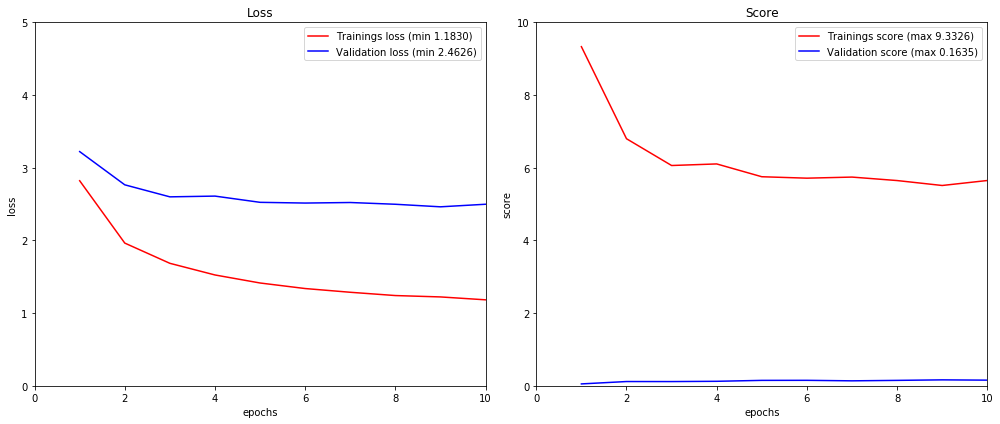

In [19]:
plot_learning_curves(m, loss_ylim=(0, 5.0), score_ylim=(0.0, 10.0), figsize=(14,6))

In [20]:
model.eval()   # Turn on evaluation mode which disables dropout and teacher_forcing.
with torch.no_grad():

    avg_loss = 0.0
    avg_score = 0.0
    for idx_batch, batch in enumerate(test_iter.__iter__()):
        input_variables, input_lengths = getattr(batch, H.src_field_name)
        target_variables = getattr(batch, H.tgt_field_name)

        decoder_outputs = model(input_variables, None)

        loss = 0
        target_length = target_variables.size(1) - 1
        for idx_seq in range(target_length):
            seq_output = decoder_outputs[idx_seq]
            loss += criterion(seq_output.contiguous(), target_variables[:, idx_seq + 1])

        avg_loss += loss.item() / (idx_seq + 1)
                
        avg_score += blue_score(decoder_outputs, target_variables)

print("Loss: ", avg_loss / (idx_batch + 1))
print("PPL: ", get_perplexity(avg_loss / (idx_batch + 1)))
print("Bleu: ", avg_score / (idx_batch + 1))

/anaconda3/lib/python3.6/site-packages/torchtext/data/field.py:321: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train), lengths
/anaconda3/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)


Loss:  2.4905223673628756
PPL:  5.619813942602337
Bleu:  0.1562485560339747


In [ ]:
while True:
    seq_str = input("Type in a source sequence:")
    print(">> ", seq_str)
    if not len(seq_str):
        break
    #seq = seq_str.strip().lower().split()
    seq = tokenize_en(seq_str.strip().lower())
    print(seq)

    seq_id = [input_vocab.stoi[tok] for tok in seq]

    model.eval()
    with torch.no_grad():

        src_id_seq = Variable(torch.LongTensor(seq_id)).view(1, -1)

        src_id_seq = src_id_seq.cuda() if torch.cuda.is_available() else src_id_seq

        decoder_outputs = model(src_id_seq, None)
        tokens = [step_output[-1].topk(1)[1].item() for step_output in decoder_outputs]
        
        tokens = np.array(tokens)
        idx = np.equal(tokens, 2).nonzero()
        if idx[0] :
            idx = idx[0][0]
            tokens = tokens[0:idx]
        
        tgt_seq = [output_vocab.itos[tok] for tok in tokens]

        print("<< ", ' '.join(tgt_seq))

print("Finished.")

Type in a source sequence:What's your name?
>>  What's your name?
['what', "'s", 'your', 'name', '?']
<<  wie ist dein name ?
Type in a source sequence:Where do you live?
>>  Where do you live?
['where', 'do', 'you', 'live', '?']
<<  wo wohnen sie ?
Type in a source sequence:Hello
>>  Hello
['hello']
<<  hallo !
Type in a source sequence:We are traveling.
>>  We are traveling.
['we', 'are', 'traveling', '.']
<<  wir reisen .
Type in a source sequence:This has no effect.
>>  This has no effect.
['this', 'has', 'no', 'effect', '.']
<<  das hat keine wirkung .
